In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import os

In [34]:
tick_font_size = 16
axis_label_font_size = 16
legend_font_size = 16
line_width = 3

def load_fes(fes_file):
    """Load PLUMED-generated FE surface."""
    data = np.loadtxt(fes_file, comments="#")
    if data.ndim == 1: return np.array([]), np.array([])
    x = data[:,0]
    f = data[:,1] - np.min(data[:,1])
    return x, f

def load_hills(hills_path):
    """Load PLUMED HILLS file."""
    data = np.loadtxt(hills_path, comments="#")
    return data[:, 0], data[:, 3] # Time, Height

def shift_periodic(x, f, shift=np.pi):
    xs = (x + shift + np.pi) % (2*np.pi) - np.pi
    idx = np.argsort(xs)
    return xs[idx], f[idx]

def get_color(filename):
    color_AT = "#332288"
    colors = ["#88CCEE","#44AA99", '#DDCC77', '#CC6677']
    if "AT" in filename or "Atomistic" in filename: return color_AT
    if "coreBeta" in filename or "Core Beta" in filename: return colors[1]
    if "hmerged" in filename or "United Atom" in filename: return colors[3]
    if "heavyOnly" in filename or "Heavy Atom" in filename: return colors[2]
    return 'black' 

def get_label(filename):
    if "coreBeta" in filename: return "Core Beta"
    if "heavyOnly" in filename: return "Heavy Atom"
    if "hmerged" in filename: return "United Atom"
    if "AT" in filename: return "Atomistic (Implicit Solvent)"
    return "Unknown"

def analyze_fes_and_convergence(fes_files, shift=np.pi):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Initialize lists to return
    return_labels = []
    barrier_dFE = []
    
    for i, fes_file in enumerate(fes_files):
        # --- 1. PLOT FES (Left Panel) ---
        x, f = load_fes(fes_file)
        if len(x) == 0: continue 

        xs, fs = shift_periodic(x, f, shift=shift)
        filename = fes_file
        color = get_color(filename)
        label = get_label(filename)
        
        xs_deg = np.degrees(xs)
        
        linestyle = '-'
        if 'tr=0.02' in fes_file:
            label = f"{label} (2%)"
            linestyle = '--'

        ax[0].plot(xs_deg, fs, color=color, lw=line_width, label=label, linestyle=linestyle)

        # Extrema and Barrier Calculation
        mins = argrelextrema(fs, np.less, order=10)[0]
        maxs = argrelextrema(fs, np.greater, order=10)[0]
        
        if len(mins) > 0 and len(maxs) > 0:
            current_barrier = fs[maxs].max() - fs[mins].min()
            barrier_dFE.append(current_barrier)
            return_labels.append(label)
        
        ax[0].scatter(xs_deg[mins], fs[mins], color=color, s=60)
        ax[0].scatter(xs_deg[maxs], fs[maxs], color=color, marker="^", s=60)

        # --- 2. PLOT CONVERGENCE (Right Panel) ---
        base_dir = os.path.dirname(fes_file)
        hills_path = os.path.join(base_dir, "HILLS")
        if not os.path.exists(hills_path): hills_path = os.path.join(base_dir, "HILLS.dat")
        
        if os.path.exists(hills_path):
            time, height = load_hills(hills_path)
            time_ns = time / 1000.0 
            
            # --- SCATTER PLOT CHANGES ---
            # 1. Stride: Plot only every 10th point to reduce density
            stride = 1 
            if len(time_ns) > 10000: stride = 50 # Increase stride for very long sims
            
            # 2. Scatter: Use small markers (s=10) and transparency (alpha=0.5)
            ax[1].scatter(time_ns[::stride], height[::stride], 
                            color=color, s=15, alpha=0.5, edgecolors='none')


    # --- FORMATTING ---
    # Left Panel
    ax[0].set_xlabel(r"Improper Dihedral $\chi$ (deg)", fontsize=axis_label_font_size)
    ax[0].set_ylabel("Free Energy (kcal/mol)", fontsize=axis_label_font_size)
    ax[0].tick_params(labelsize=tick_font_size)
    ax[0].set_xlim(-150, 150)
    
    current_ticks = ax[0].get_xticks()
    xticks_shifted = (current_ticks + np.degrees(shift)) % 360
    xticks_shifted[xticks_shifted > 180] -= 360
    ax[0].set_xticklabels([f"{v:.0f}" for v in xticks_shifted])

    # Right Panel
    ax[1].set_xlabel("Simulation Time (ps)", fontsize=axis_label_font_size)
    ax[1].set_ylabel("Gaussian Height (kJ/mol)", fontsize=axis_label_font_size)
    ax[1].tick_params(labelsize=tick_font_size)
    ax[1].set_title("WTMetaD Convergence", fontsize=axis_label_font_size)
    ax[1].grid(alpha=0.3)
    
    # --- LOG SCALE (Recommended for WTMetaD Heights) ---
    # ax[1].set_yscale('log') 

    handles, labels = ax[0].get_legend_handles_labels()

    plt.tight_layout()
    fig.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.01),
        ncol=2,
        fontsize=legend_font_size,
        frameon=False
    )
    plt.subplots_adjust(bottom=0.25)
    plt.savefig("FES_and_Convergence.pdf", dpi=300)

    plt.show()
    
    return return_labels, barrier_dFE

/tmp/ipykernel_2643928/584411943.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f"{v:.0f}" for v in xticks_shifted])


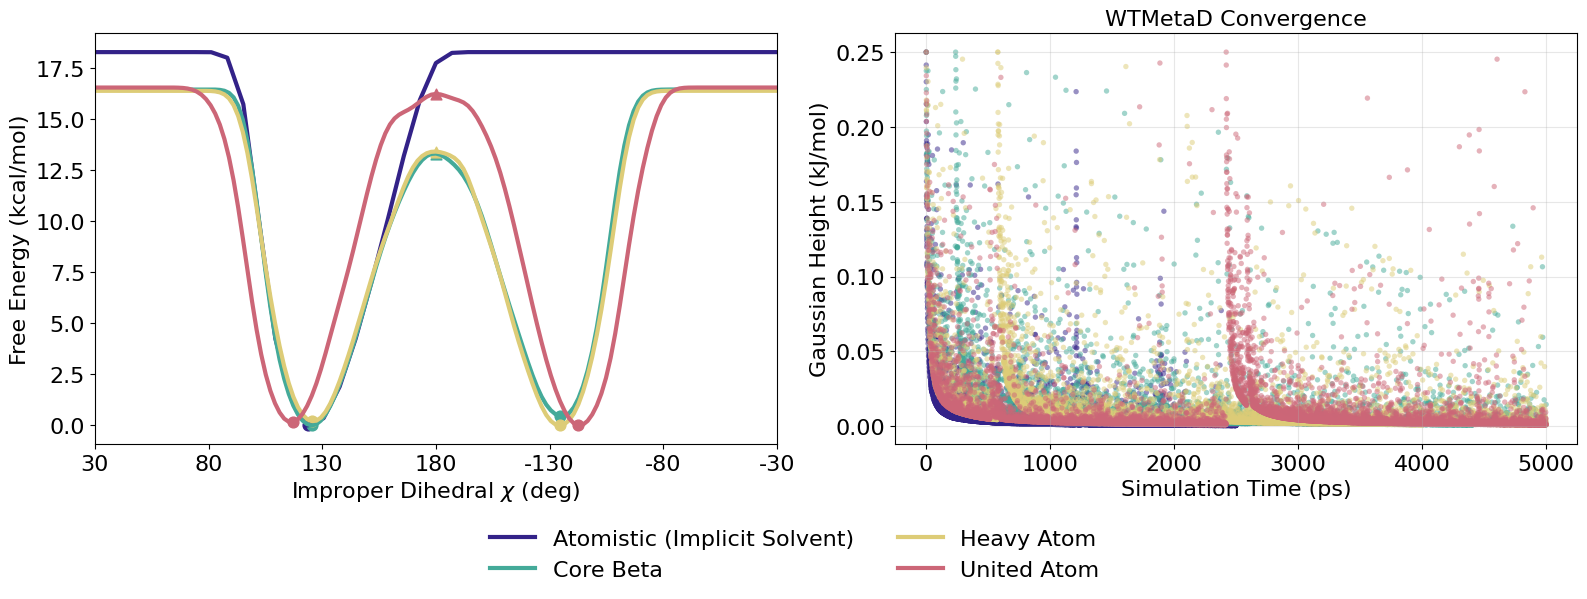

In [ ]:
HILLS_PATHS = [
    "/home/franz/CG-Mapping-Benchmark/Chirality_inversion/metadynamics/AT_tr=0.9/t=2.5ns_PACE=100_H=0.2_s=0.1_BIAS=8/HILLS",
    "/home/franz/CG-Mapping-Benchmark/Chirality_inversion/metadynamics/coreBeta_tr=0.9/t=5ns_PACE=100_H=0.2_s=0.1_BIAS=5/HILLS",
    "/home/franz/CG-Mapping-Benchmark/Chirality_inversion/metadynamics/heavyOnly_tr=0.9/t=5ns_PACE=100_H=0.2_s=0.1_BIAS=5/HILLS",
    "/home/franz/CG-Mapping-Benchmark/Chirality_inversion/metadynamics/hmerged_tr=0.9/t=5ns_PACE=100_H=0.2_s=0.1_BIAS=5/HILLS",
]

# CHANGE LD_LIBRARY_PATH TO POINT TO YOUR PLUMED INSTALLATION
os.environ['LD_LIBRARY_PATH'] = '/home/franz/lammps/lammps-29Aug2024/build/plumed_build-prefix/lib:$LD_LIBRARY_PATH'

fes_files = []
for hills_path in HILLS_PATHS:
    fes_output_path = hills_path.replace("HILLS", "fes.dat")
    if os.path.exists(fes_output_path):
        os.remove(fes_output_path)
    cmd = f"plumed sum_hills --hills {hills_path} --outfile {fes_output_path} --mintozero"    
    os.system(cmd + " > /dev/null 2>&1")
    fes_files.append(fes_output_path)
    
labels, barrier_dFE = analyze_fes_and_convergence(fes_files, shift=np.pi)

In [36]:
labels, barrier_dFE

(['Core Beta', 'Heavy Atom', 'United Atom'],
 [13.307117471, 13.401965516, 16.224265614])

Plot saved.


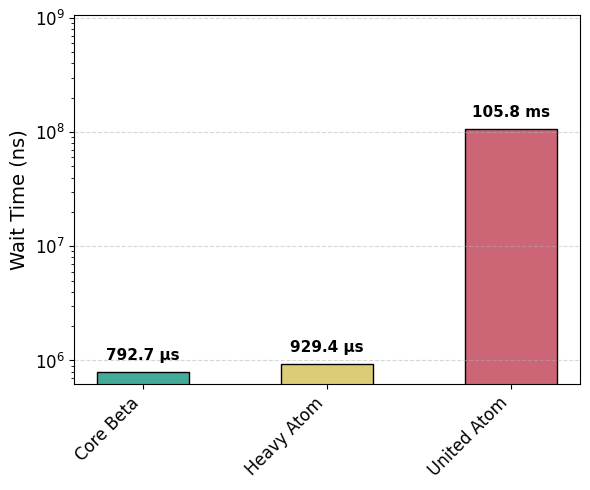

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np

def calculate_wait_time(temp_k, barrier_kcal_mol):
    # Constants
    R = 0.001987  # kcal/(mol*K)
    kB = 1.380649e-23 # J/K
    h = 6.626070e-34  # J*s
    
    # 1. Wait Time Calculation
    # frequency (v) = (kB * T) / h
    freq = (kB * temp_k) / h
    
    # probability = exp(-dG / RT)
    prob = math.exp(-barrier_kcal_mol / (R * temp_k))
    
    # Rate (k) and Wait time (tau)
    rate_k = freq * prob
    
    # Avoid division by zero if rate_k is extremely small (though unlikely here)
    if rate_k == 0:
        return float('inf')
        
    wait_time_ns = (1 / rate_k) * 1e9
    
    return wait_time_ns


temp_k = 300
axis_label_font_size = 14
tick_font_size = 12
legend_font_size = 11

# Calculate Wait Times
wait_times = [calculate_wait_time(temp_k, b) for b in barrier_dFE]

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(6, 5))

colors = [get_color(f) for f in labels]
bars = ax.bar(
    labels, 
    wait_times, 
    width=0.5, 
    color=[
        colors[i]
        for i, label in enumerate(labels)
    ], 
    edgecolor='black', 
    hatch=[
        '' if '2%' not in label else '//' 
        for label in labels
    ]
)

# Set Y-axis to log scale
ax.set_yscale('log')

# Labels and Title
ax.set_ylabel('Wait Time (ns)', fontsize=axis_label_font_size)
plt.xticks(rotation=45, ha='right', fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Set Y-axis limits to make room for text above the tallest bar
# On log scale, multiplying the max creates visual vertical space
max_wait = max(wait_times)
ax.set_ylim(top=max_wait * 10) 

# Add annotations on top of bars
for bar, wait_ns in zip(bars, wait_times):
    height = bar.get_height()
    
    # Format readable wait time
    if wait_ns >= 1e9:
        readable = f"{wait_ns/1e9:.1f} s"
    elif wait_ns >= 1e6:
        readable = f"{wait_ns/1e6:.1f} ms"
    elif wait_ns >= 1000:
        readable = f"{wait_ns/1000:.1f} µs"
    else:
        readable = f"{wait_ns:.1f} ns"
        
    # Positioning
    # get_x() + get_width()/2 ensures text is always center of bar
    text_x = bar.get_x() + bar.get_width() / 2
    
    # Multiply height by factor to float text above bar in log scale
    text_y = height * 1.2 
    
    ax.text(text_x, text_y, readable,
            ha='center', va='bottom', 
            fontsize=legend_font_size, 
            fontweight='bold',
            color='black')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and Show
plt.savefig('wait_times_bar_plot.pdf')
print("Plot saved.")